---

# <h1 style="text-align: center;">**A persistent homology clustering approach for evaluating pollution severity worldwide**</h1>
### <h3 style="text-align: center;">*Typology of Final Project:* ***Method over Data***</h3>

---

### Group 06: SoloLacrime

| STUDENT | ID |
| :-: | :-: |
| Francesco Lazzari | 1917922 |
| Camilla Brigandì | 2055650 |  
| Riccardo Violano | 2148833 | 
| Matteo Pazzini | 1868953 |
| Paolo Meli | 1920140 |

In [1]:
# ------------------------------
# --        LIBRARIES         --
# ------------------------------

import pandas as pd
import numpy as np
from sklearn import datasets
import gudhi as gd
from tqdm import tqdm
import ast

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as pyo
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium

from prince import PCA
from sklearn.preprocessing import StandardScaler

import networkx as nx
from sklearn.neighbors import kneighbors_graph

from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")

# ------------------------------
# --     Custom Functions     --
# ------------------------------

from Functions import plot_graph_with_labels, cluster_cardinality, pca_3d_scatterplot, find_best_hdbscan_params, find_best_spectral_params

# -------------------------------
# --      Work Diirectory      --
# -------------------------------

path = r"/Users/francescolazzari/Documents/Università - Data Science/SL/Homework/Final Project"

---

### <h3 style="text-align: center;">**NNVR Filtration**</h3> 

---

By definition, given of a metric space (X,d) (or better: a finite subset of it), its NNVR filtration $NNVR(X, \alpha)$ is defined according to the following:

$$
\forall x \in X, x \in NNVR(X, \alpha)\iff \alpha \geq \inf_{y \in X, y \neq x} d (x, \, y)
$$

To create the **NNVR filtration** of a point cloud we took leverage of some functions in the library *GUDHI* (https://gudhi.inria.fr/index.html). This library uses a "special" data structure called *SimplexTree* to encode filtrations of a metrical/topological space. For this project we wrote two functions to encode the NNVR filtration: 
- `NNVR` which takes in input the matrix of the coordinates of the points in the point cloud we're dealing with and computes the $NNVR$ filtration using the euclidean distance between them through the `eu_dist` function;
- `NNVR_fromdistance` which takes in input a matrix of distances between the points and constructs the $NNVR$ filtration starting from it.

To be more precise, the first function starts by computing the euclidean distances between all the couple of points we give in input, then sets the values in the upper triangular part of the matrix to $+ \infty$ (including the diagonal ones), selects the couple of points whose mutual distance is below the filtration value $\alpha$, sorts them according to their mutual distance and inserts all the corrisponding simplexes in the SimplexTree following this order.

Note that the "insert" method of the GUDHI library authomatically insert the vertices of the edges added to make sure that the inclusion proprerty of a filtered copmplex is satisfied, so there's no need to add the vertces singularly. Besides the "time stamp" at which they're added is the same as the 1-simplex they correspond, so we first sort all the couples of points according to their reciprocal distance in order to make sure that the vertices are added at the correct level filtration.

Usually, in order to make sure that no important relationship is left out of the filtration, we set the value of $\alpha$ slightly above the maximum distance registered in the matrix.

In [5]:
# Get euclidean distances of all the couple of points in the array 
def eu_dist(points, flag):
    """Returns a matrix M s.t. M[i,j] = dist(points[i], points[j]),
    where dist is the euslidean distance (in R2); 
    flag = 0 if the points are stored as columns, flag = 1 elseway"""
    
    if not flag: 
        # Preallocate memory
        m, n = np.shape(points) # Each column is a point
        d_matrix = np.empty(shape = (n,n)) 

        for i in range(n):
            # Create a matrix containing the differences between the current point and all the others
            current_point = np.reshape(points[:, i], (m,1)) # 2 since we are always in R2 for this application 
            diff_matrix = points - current_point # automatic broadcasting 

            # Computing the distance vector and saving it
            d_matrix[i, :] = np.sqrt( np.sum(diff_matrix **2, axis = 0) )

        return d_matrix
        
    else:
        pointsT = np.transpose(points)
        distances = eu_dist(pointsT, flag = 0)

        return distances

def NNVR(X : np.array, alpha: float, flag):
    """flag is 0/1 according to the flag of rhe eu_dist function"""
    
    # Matrix containing euclidean distance of all the couples of points 
    d_matrix = eu_dist(X, flag)
    # Set the diagonal of the matrix to inf
    np.fill_diagonal(d_matrix, np.inf)
    # Set all the upper triang part of the matrix to infty
    d_matrix[np.where(np.triu(d_matrix))] = np.inf
    # Select the couple of points whose mutual distance is at most the threshold alpha (and their mutual distance)
    idx = np.where(d_matrix <= alpha)
    dist_vec = d_matrix[idx]

    idxT = np.transpose(idx) # Transposed indices because that's how the pairs of points (or rather the pairs of inidices corresponding to the points) come out
    
    # Sort distance vetor 
    idx_sort = np.argsort(dist_vec)
    dist_sort = dist_vec[idx_sort]

    couples_sort = idxT[idx_sort]
   
    # Creation of the NNVR filtration 
    NNVR_ST = gd.SimplexTree()
    for i in range(len(couples_sort)):
        current_couple = list(couples_sort[i])
        NNVR_ST.insert(current_couple, filtration= dist_sort[i])
        
    return NNVR_ST

The second function operates exactly as the first one, exclluding the part of the computation of the ditances, which are already given, and the fact that it first creates a copy of the matrix of distances in order to not overwrite the original one when setting some values of it to $+ \infty$.

Note that the this function doesn't necessarily take in input *euclidean* distances between a finite set of points in $\mathbb{R}^d$, making it more versatile than the previous one. 

In [6]:
def NNVR_fromdistance(d_matrix: np.array, alpha: float):
    dist = d_matrix.copy()
    # Set the diagonal of the matrix to inf
    np.fill_diagonal(dist, np.inf)
    # Set all the upper triang part of the matrix to infty
    dist[np.where(np.tril(dist))] = np.inf
    # Select the couple of points whose mutual distance is at most the threshold alpha (and their mutual distance)
    idx = np.where(dist <= alpha)
    dist_vec = dist[idx]

    idxT = np.transpose(idx) # Transposed indices because that's how the pairs of points (or rather the pairs of inidices corresponding to the points) come out
    
    # Sort distance vetor 
    idx_sort = np.argsort(dist_vec)
    dist_sort = dist_vec[idx_sort]

    couples_sort = idxT[idx_sort]
   
    # Creation of the NNVR filtration 
    NNVR_ST = gd.SimplexTree()
    for i in range(len(couples_sort)):
        current_couple = list(couples_sort[i])
        NNVR_ST.insert(current_couple, filtration= dist_sort[i])
        
    return NNVR_ST

In order to test our implementation of the NNVR filtration we're going to generate some artificial data, call it $X$, and see if $NNVR(X, \alpha)$ contains the same simplexes as $VR(X, \alpha)$ for the same value of $\alpha$ and if the 1-simplices of the two filtration have the same filtration value (the "time stamp" at which they are inserted). We check this because following from the definition of the two filtrations we're considering, we have that: $\forall k \geq 1$, for all $k$ - simplices $\sigma$, 
$$
\sigma \in NNVR(X, \alpha)\iff \sigma \in VR(X, \alpha)
$$


In [7]:
# Create some points in R2
art_data = [ (a, b) for a in range(5) for b in range(3)]
art_data = list(set(art_data)) # Delete duplicates
art_data_np = np.array(art_data) # Convert to numpy array

# Check the shape of the np array to set the flag of the eu_dist function
np.shape(art_data_np)

(15, 2)

The shape of the np.array containing the artificial data is $(15, 2)$, meaning that the points are stored as rows, so the flag of eu_dist has to be set to 1.

In [46]:
art_st = NNVR(art_data_np, alpha= 5, flag= 1)
art_filt = art_st.get_filtration()
df_NNVR = pd.DataFrame(art_filt)

VR = gd.RipsComplex(points=art_data, max_edge_length=5.0).create_simplex_tree(max_dimension=1)
VRf = VR.get_filtration()
df_VR = pd.DataFrame(VRf)

df_NNVR = df_NNVR.rename({0 : "Simplex", 1: "NNVR Birth Time"}, axis =1 )
df_NNVR = df_NNVR[ df_NNVR["Simplex"].apply(len) == 2 ]

df_VR = df_VR.rename({0 : "Simplex", 1: "VR Birth Time"}, axis =1 )
df_VR = df_VR[ df_VR["Simplex"].apply(len) == 2 ]

df_NNVR = df_NNVR.sort_values(by = "Simplex", ignore_index = True)
df_VR = df_VR.sort_values(by = "Simplex", ignore_index = True)

df_NNVR[ "VR Birth Time" ] = df_VR["VR Birth Time" ]
df_NNVR

,Simplex,NNVR Birth Time,VR Birth Time
0,"[0, 1]",1.414214,1.414214
1,"[0, 2]",4.123106,4.123106
2,"[0, 3]",2.000000,2.000000
3,"[0, 4]",1.000000,1.000000
4,"[0, 5]",3.000000,3.000000
...,...,...,...
100,"[11, 13]",1.000000,1.000000
101,"[11, 14]",2.236068,2.236068
102,"[12, 13]",2.828427,2.828427
103,"[12, 14]",3.162278,3.162278


In [52]:
# Check if there's at least one value with different birth time
False in df_NNVR["NNVR Birth Time"] == df_NNVR["VR Birth Time"]

False

---

### <h3 style="text-align: center;">**Persistent Homology Clustering Algorithm**</h3> 

---

Citing directly from the article, *the clustering algorithm works as follows:* 
> ```text
>• Input: a finite metric space (X, d);
>• Compute the filtration NNVR(X) and its 0-dimensional persistence diagram;
>• Choose a birth threshold and a persistence threshold;
>• Mark all points whose birth dates are above the birth threshold as outliers. Let Y be the remaining points;
>• Compute 0-dimensional persistent homology on NNVR(Y), but do not add edges that would merge components whose persistence is above the persistence threshold;
>• Output: a simplicial complex, where each connected component is a cluster.

From what we just wrote, it's clear that we need to choose both a *persistence thereshold* and a *birth threshold* where the latter can be omitted if we know, or at least believe, that there are no outliers in the dataset.


One options to choose these two quantities is to use the `maxjump` algorithm described in the article, that is the one in the following image implemented with the homonymous function.

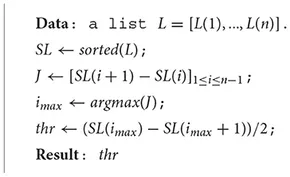

In [6]:
def maxjump(L):
    L = np.array(L)
    sorted_L = np.sort(L)
    jumps =  sorted_L[1:] - sorted_L[:-1]
    max_idx = np.argmax(jumps)
    
    #threshold = (sorted_L[max_idx+1] - sorted_L[max_idx-1]) /2 #negative output

    threshold = jumps[max_idx]/2
    
    return threshold

<code style="background:darkred;color:black">**Important Note:**</code>

The algorithm in the photo gives back a negative threshold. We believe that it's simply a sign error, given that computing $\text{SL}[i_{max} +1 ] - \text{SL}[i_{max}]$ gives back the correct output if compared to the ones in the examples of the article. 

Once the *birth threshold* is obtained, we have to exclude the point whose birth time is above it. The `get_outliers` function computes the birth moments of all the points (0-simplices) taken into analysis, and returns the outliers indeces.

In [7]:
def get_outliers(d_matrix, birth_threshold):
    # Set the diagonal values to infty (elseway all the birth moments would be 0)
    np.fill_diagonal(d_matrix, np.inf)

    # Birth moments for the 0-simplexes
    min_dist = np.min(d_matrix, axis = 0)  

    # Select the points whose birth moment is above the birth threshold 
    idx_outliers = set(np.array( np.where(min_dist > birth_threshold) ).flatten())

    return idx_outliers

The last function that we need is the one that, given a matrix or distances (or points) without considering the outliers, and a persistence threshold, returns the clusters computed as described in the algorithm. 

The `NNVR_clus` function does exactly this, while also having options to save some information regarding the persistence pairs and intervals of the NNVR filtration resulting from the starting points. We included this options since for large datasets the computations needed to obain persistence pairs take a very big amount of time. On the other hand, these won't vary, so if we want to try different persistence thresholds to compute different clusters, we can do this while saving a lot of time.

In [8]:
def NNVR_clus(X: np.array, alpha: float, persistence_threshold, flag_eudist, flag_distancematrix, save_persistencedf, path):
    """
    X is a matrix of points (if flag_distancematrix = 0) or of distances (if flag_distancematrix = 1);
    alpha is the threshold value for the NNVR filtration;
    persistence_threshold is the omonymous threshold of the clustering algorithm described above;
    flag_eudist is 0/1 according to the function eu_dist;
    save_persistencedf is a boolean variable: True if we want to save the information about the persistence of the filtration in csv;
    path is the path in which the .csv file of "persistence_df" will be saved if the previous variable is True.
    """

    print("Constructing NNVR filtration...")
    # Construct NNVR filtration of the pointcloud (after removing the outliers!!)
    if flag_distancematrix == 0:
        NNVR_st = NNVR(X, alpha, flag = flag_eudist)
    else:
        NNVR_st = NNVR_fromdistance(X, alpha)

    print("Retrieving persistence infromation")
    # Need to compute persistence before calling .persistence_pairs()
    NNVR_st.compute_persistence(min_persistence=-1) 

    # Exctract information about the persistence pairs
    persistence_df = pd.DataFrame(NNVR_st.persistence_pairs())
    persistence_df.rename({0: "BS", 1: "DS"}, axis = 1, inplace = True)
    persistence_df["BT"] = persistence_df.BS.apply(lambda el: NNVR_st.filtration(el))
    persistence_df["DT"] = persistence_df.DS.apply(lambda el: NNVR_st.filtration(el))
    persistence_df["Persistence"] = persistence_df["DT"] - persistence_df["BT"] 

    # Save dataframe with informations about the persistence if requested 
    if save_persistencedf:
        persistence_df.to_csv(path)
    
    print("Computing clusters ...")
    # Create simplex tree corresponding to NNVR filtration excluding the edges that would make the persistence higher than the threshold 
    st_perspairs = gd.SimplexTree()

    for simplex in tqdm(persistence_df["BS"]):
        st_perspairs.insert(simplex, filtration = NNVR_st.filtration(simplex))

    for i in tqdm(range(len(persistence_df))):
        if persistence_df["Persistence"][i] < persistence_threshold:
            simplex = persistence_df["DS"][i]
            st_perspairs.insert(simplex, filtration = NNVR_st.filtration(simplex))

    st_perspairs.compute_persistence(min_persistence=-1)
    
    # Compute the clusters by finding the connected components of the resulting graph
    cluster_graph = nx.Graph()
    cluster_graph.add_edges_from([ tuple(el[1]) for el in st_perspairs.persistence_pairs() if len(el[1]) == 2])

    clusters = list(nx.connected_components(cluster_graph))

    # NNVR_st will be returned because it can be useful for us to have it without recomputing it
    return clusters, NNVR_st 

The `NNVR_clusters_from_dataframe` function computes the clusters following the algorithm described in the article starting with the needed information about the persistence pairs and corresponding interval alrrady computed. It's useful for us to try differente *persistence threshold* values without recomputing them every time.

In [9]:
def NNVR_clusters_from_dataframe(persistence_df, persistence_threshold):
    
    # Exclude edges that would merge components whose persistence would be above the threshold
    st_perspairs = gd.SimplexTree()

    for i in range(len(persistence_df)):
        simplex = persistence_df["BS"][i]
        st_perspairs.insert(simplex, filtration = persistence_df["BT"][i])

    for i in range(len(persistence_df)):
        if persistence_df["Persistence"][i] < persistence_threshold:
            simplex = persistence_df["DS"][i]
            st_perspairs.insert(simplex, filtration = persistence_df["DT"][i])

    st_perspairs.compute_persistence(min_persistence=-1)
    
    # Compute the clusters by finding the connected components of the resulting graph
    cluster_graph = nx.Graph()
    cluster_graph.add_edges_from([ tuple(el[1]) for el in st_perspairs.persistence_pairs() if len(el[1]) == 2])

    clusters = list(nx.connected_components(cluster_graph))

    return clusters

---

### <h3 style="text-align: center;">**Test of the clustering algorithm**</h3> 

---

To test that our algorithm works correctly, we recreated the toy examples contained in the article and checked our results.

#### <code style="background:darkgreen;color:black">**Example N1**</code>

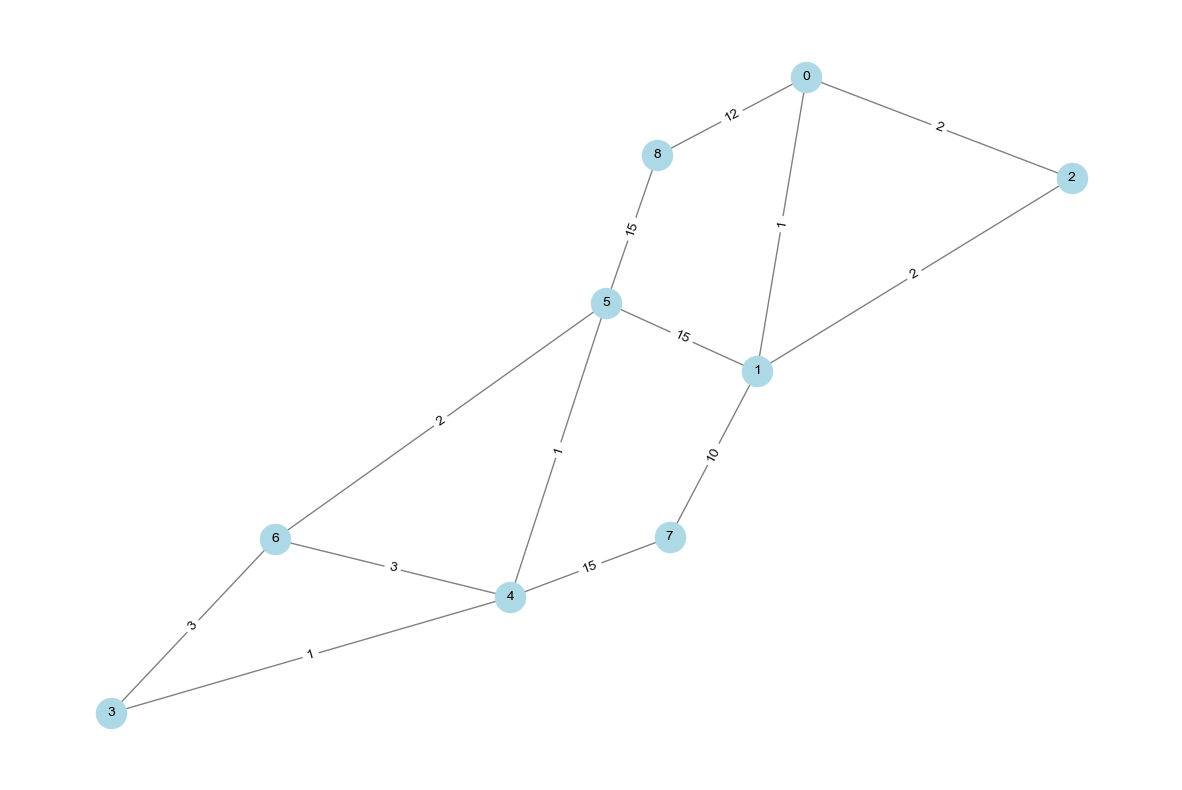

In [10]:
# Create Graph object with the same structure of the one in the article and plot it
G = nx.Graph()
G.add_weighted_edges_from([(0,1,1)])
G.add_weighted_edges_from([(0,2,2)])
G.add_weighted_edges_from([(1,2,2)])


G.add_weighted_edges_from([(0,8,12)])
G.add_weighted_edges_from([(1,7,10)])
G.add_weighted_edges_from([(1,5,15)])

G.add_weighted_edges_from([(8,5,15)])
G.add_weighted_edges_from([(7,4,15)])

G.add_weighted_edges_from([(5,4,1)])
G.add_weighted_edges_from([(4,6,3)])
G.add_weighted_edges_from([(5,6,2)])

G.add_weighted_edges_from([(4,3,1)])
G.add_weighted_edges_from([(3,6,3)])

plot_graph_with_labels(G)

For this example, we have to construct a matrix containing the edges weights and use it as a matrix of distances.

In [11]:
# Construct the weights matrix
n = len(G.nodes)
weights_matrix = np.full((n, n),np.inf)

for u, v, data in G.edges(data=True):
    weights_matrix[u][v] = data['weight']
    if not G.is_directed():
        weights_matrix[v][u] = data['weight']  # For non directed graphs


# Compute the NNVR filtration
test_g = NNVR_fromdistance(weights_matrix, alpha = 16)

# Compute the persistence barcodes
bcodes_g = test_g.persistence(min_persistence=-1)

# Extract birth times and death times from the persistence barcodes
birth_times_g = np.array([el[1][0] for el in bcodes_g])
death_times_g = np.array([el[1][1] for el in bcodes_g])

# Compute persistence
persist_g = death_times_g - birth_times_g

# Compute thresholds using maxjump
birth_threshold_g = maxjump(birth_times_g)
pers_threshold_g = maxjump(persist_g[1:])

print("Birth threshold:", birth_threshold_g, "\nPersistence threshold:", pers_threshold_g)

Birth threshold: 4.0 
Persistence threshold: 7.0


If we now look at the persistence diagram, we know that with these threshold we should have 2 different clusters and 2 outliers.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

<Figure size 1500x1000 with 0 Axes>

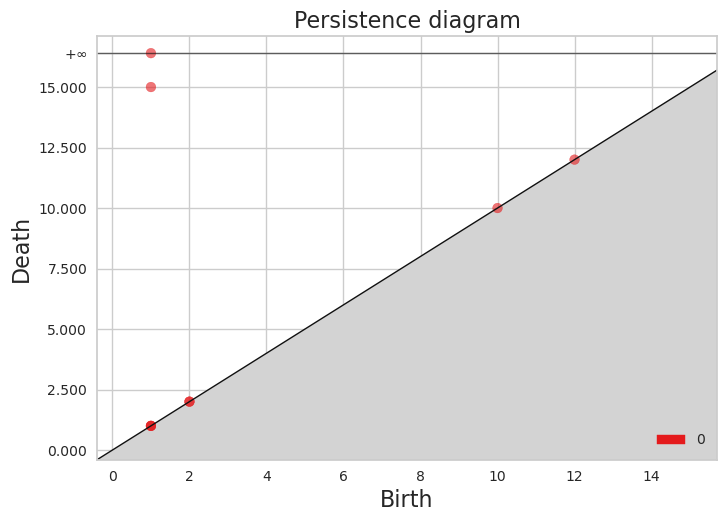

In [15]:
gd.plot_persistence_diagram(test_g.persistence(min_persistence=-1))

Let's see which are the outliers we get. 

In [16]:
outliers_g = get_outliers(weights_matrix, birth_threshold_g)
print("The outliers detected are:", outliers_g)

The outliers detected are: {8, 7}


To exclude the outliers from the computations of the clusters, we only need to construct a subgraph excluding them, and select the corresponding submatrix from the original one.

Constructing NNVR filtration...
Retrieving persistence infromation
Computing clusters ...


100%|██████████| 7/7 [00:00<00:00, 54270.11it/s]


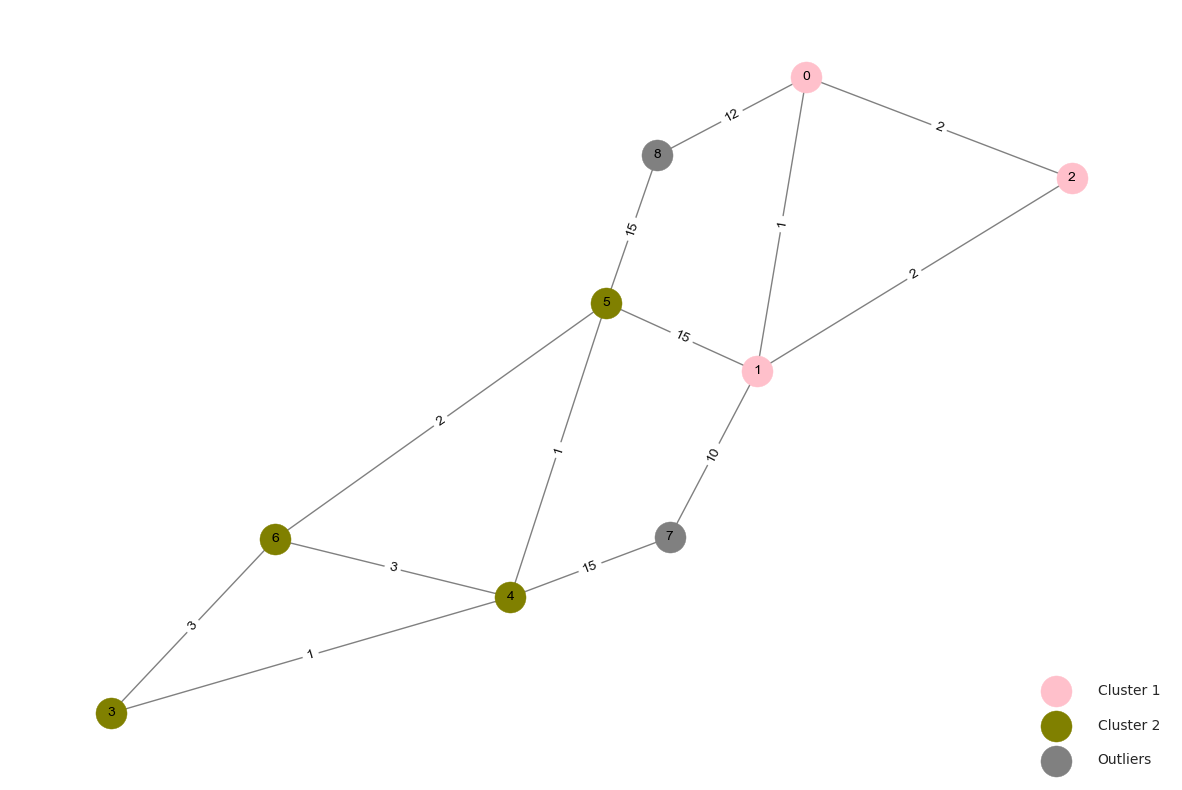

In [26]:
# SUbgraph that excludes the outliers
G2 = nx.subgraph(G, range(7))

# Corresponding weights matrix
weights_matrix_G2 = weights_matrix[:7, :7]

# Compute clusters 
clusters_toy, _ = NNVR_clus(weights_matrix_G2, 
                         alpha= 16, 
                         persistence_threshold= pers_threshold_g, 
                         flag_eudist= 0, 
                         flag_distancematrix= 1, 
                         save_persistencedf= 0,
                         path= "")


# Plot the resulting clusters 
# Choose colors
col = [ "pink", "olive"] 
clus_labels = ["Cluster 1", "Cluster 2"]
# Set plot environment
plt.figure(figsize=(15, 10)) 
# Set positions 
pos = nx.spring_layout(G, seed=47)

for i in range(len(clusters_toy)):
    # Draw the nodes 
    nx.draw_networkx_nodes(G, pos, node_color=col[i], nodelist = list(clusters_toy[i]), node_size=500, label=clus_labels[i])

# Add the outliers to the plot
nx.draw_networkx_nodes(G, pos, node_color="gray", nodelist = list(outliers_g), node_size=500, label = "Outliers")

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist= G.edges(), edge_color='gray')
# Node indeces
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
# Edge weights 
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
# Add the legend
plt.legend(loc='lower right', handlelength=2, handletextpad=2, labelspacing=1.5)

plt.axis('off')
plt.show()

From the previous plot, we can see that the results we obtained are exactly the same as the ones of the authors.

#### <code style="background:darkgreen;color:black">**Example N2 - Karate Club Graph**</code>

For this example we modified the graph accoringly to what it's wrote in the article: each weight has been substituted with its invers and the distance used is the one of the shortest path. 
Unlike the authors, we choose not to add any outliers to the graph, so we didn't compute the birth threshold and didn't remove any node from the graph.

In [27]:
# Generate the Karate Club graph
G_karate = nx.karate_club_graph()

# Generate the graph with inverse weights 
G_karate_invpesi = nx.Graph()

for u, v, w in G_karate.edges(data=True):
    inv_w = 1/w['weight']
    G_karate_invpesi.add_weighted_edges_from([(u,v,inv_w)])


# Get the number of nodes
n = len(G_karate_invpesi.nodes)

# Initialize the matrix with infinities 
M_karate = np.full((n, n), np.inf)

# Compute shortest path lengths between all pairs of nodes
complete = dict(nx.shortest_path_length(G_karate_invpesi, weight ="weight"))
for source in G_karate_invpesi.nodes:
    lengths = complete[source]
    for target, length in lengths.items():
        M_karate[source, target] = length

# Set diagonal to inf
np.fill_diagonal(M_karate, np.inf)

# Compute the NNVR filtration for the karate graph
NNVR_karate = NNVR_fromdistance(M_karate, alpha = 5)

# Compute barcodes
bcodes_karate = NNVR_karate.persistence(min_persistence = -1)

# Extract birth moments, death moments and compute the persistence
b_karate = np.array([el[1][0] for el in bcodes_karate])
d_karate = np.array([el[1][1] for el in bcodes_karate])
pers_karate = d_karate - b_karate

# Compute persistence threshold using maxjump
p_thres_karate = maxjump(pers_karate[1:])
print("Persistence threshold:", p_thres_karate)

Persistence threshold: 0.04166666666666667


Looking at the persistence threshold we obtained and at the persistence diagram plotted below, we expect to have exactly 3 clusters, the same number obtained from the authors.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

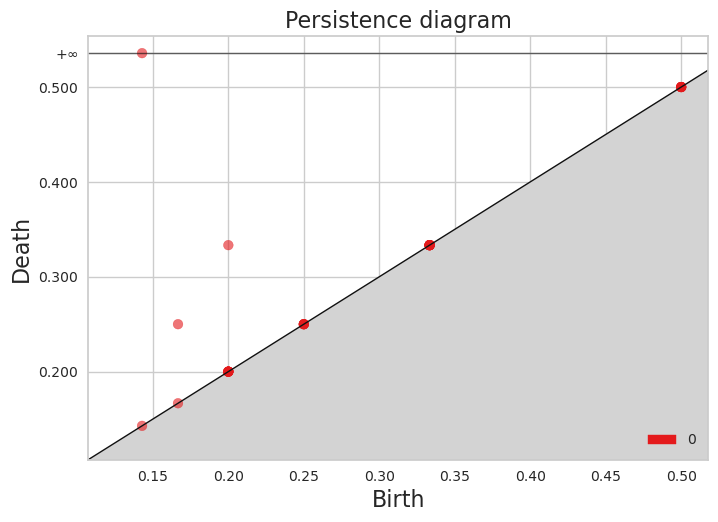

In [28]:
gd.plot_persistence_diagram(bcodes_karate)

Constructing NNVR filtration...
Retrieving persistence infromation
Computing clusters ...


100%|██████████| 34/34 [00:00<00:00, 68232.70it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


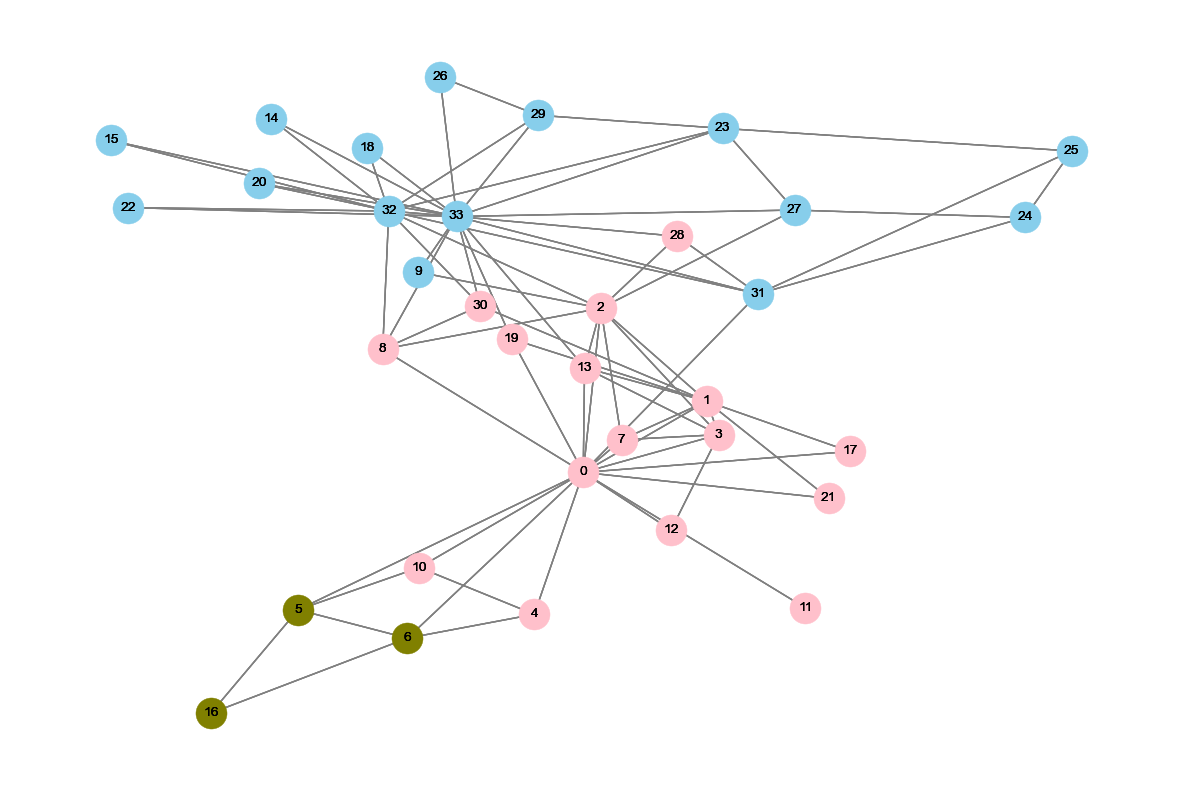

In [31]:
# Compute clusters
clusters_karate, _ = NNVR_clus(M_karate, alpha = 5, persistence_threshold= p_thres_karate, flag_eudist= 0, flag_distancematrix= 1, save_persistencedf= 0, path= "")

# Plot the results
col = ["skyblue", "pink", "olive"]
plt.figure(figsize=(15, 10))
# Use a spring layout for the nodes (this spreads them out in a visually pleasing way)
pos = nx.spring_layout(G_karate_invpesi, seed=47)
for i in range(len(clusters_karate)):
    # Draw the nodes
    nx.draw_networkx_nodes(G_karate_invpesi, pos, node_color=col[i], nodelist = clusters_karate[i], node_size=500)
    # Draw the edges
    nx.draw_networkx_edges(G_karate_invpesi, pos, edgelist=G_karate_invpesi.edges(), edge_color='gray')
    # Draw the labels
    nx.draw_networkx_labels(G_karate_invpesi, pos, font_size=10, font_color='black')

plt.axis('off')
plt.show()

For this example, we obtain results that are slightly different from the ones of the article. To be more precise, we have nodes number 10, 28 and 30 in different clusters. This is due to a different order of exploring the edge when computing the MST needed to compute persistent homology. Indeed, the nodes that are in the "wrong" cluster have the same distance from the clusters in which our implementation places them and the one in which they are in the article and if we reconstruct the MST from the persistence pairs output, we can see the edges that must be cut to have the same clusters of the authors aren't in it at all.

####  <code style="background:darkgreen;color:black">**Example N3 - "Two circles" test**</code>

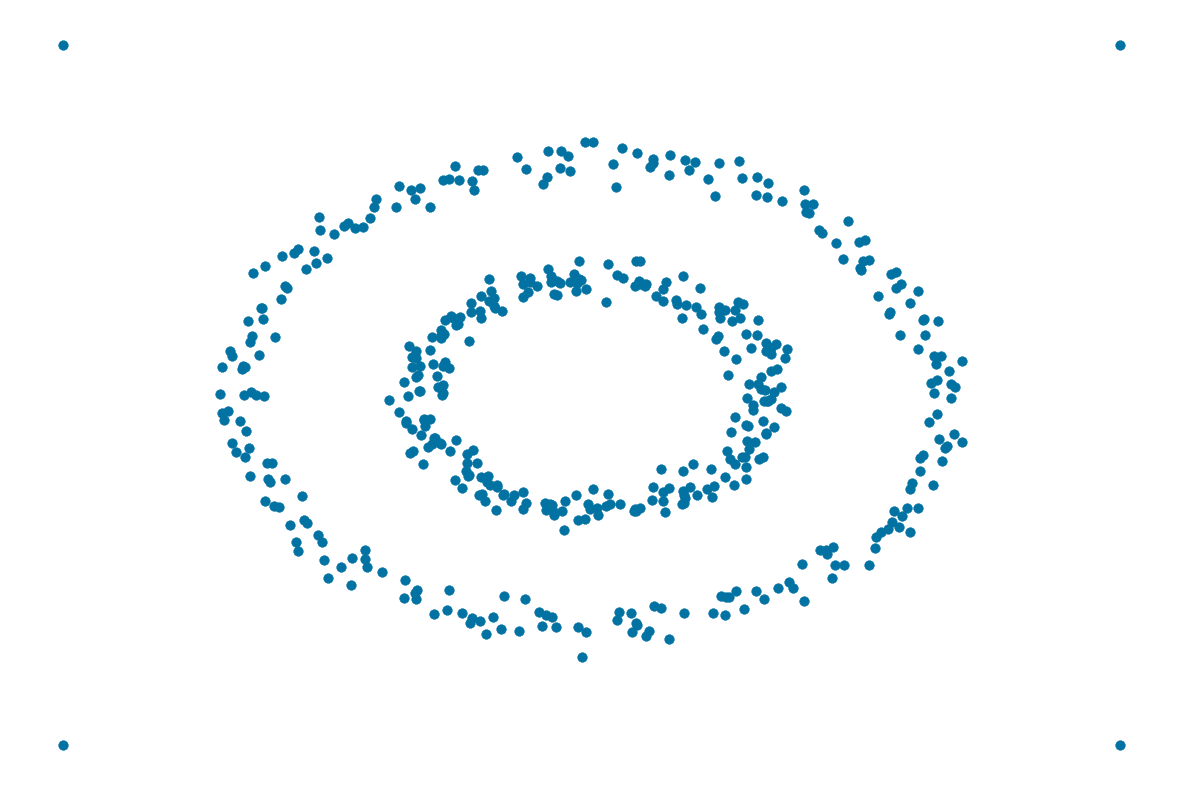

In [32]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.04, random_state=seed
)

data_2circles, label = noisy_circles

# Add outliers 
data_2circles_out = list(data_2circles)
data_2circles_out.append(np.array([-1.5, -1.5]))
data_2circles_out.append(np.array([-1.5, 1.5]))
data_2circles_out.append(np.array([1.5, 1.5]))
data_2circles_out.append(np.array([1.5, -1.5]))

data_2circles_out = np.array(data_2circles_out)

# Plot the dataset
plt.figure(figsize=(15, 10))
plt.scatter(data_2circles_out[:,0], data_2circles_out[:,1])
plt.axis('off')
plt.show()

Birth threshold: 0.4649084975179433 Persistence threshold: 0.10556991319707826


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

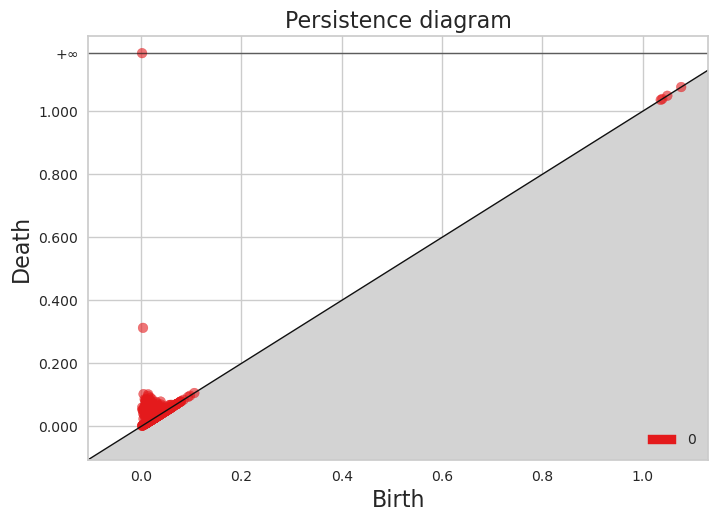

In [33]:
# Compute NNVR filtration and barcodes
nnvr_2circles_out = NNVR(data_2circles_out, 20, 1)
bcodes_NNVR_out= nnvr_2circles_out.persistence(min_persistence=-1) 

# Extract birth moments, death moments and compute the persistence
b_2circles = np.array([el[1][0] for el in bcodes_NNVR_out])
d_2circles = np.array([el[1][1] for el in bcodes_NNVR_out])
pers_2circles = d_2circles - b_2circles

# Compute birth and persistence threshold using maxjump
b_thres_2circles = maxjump(b_2circles)
p_thres_2circles = maxjump(pers_2circles[1:])
print("Birth threshold:", b_thres_2circles, "Persistence threshold:", p_thres_2circles)

# Plot persistence diagram
gd.plot_persistence_diagram(bcodes_NNVR_out)

In [36]:
outliers_2circles = get_outliers( eu_dist(data_2circles_out, flag= 1), birth_threshold= b_thres_2circles)
print("The outliers detected are:", outliers_2circles)

The outliers detected are: {500, 501, 502, 503}


Since the outliers are added at the end of the list of points and the detected ones are exactly the last four points of the list, we can say that in this case the outliers are correctly detected with the birth threshold computed with maxjump. Now we're going to compute the clusters on the original dataset (the one artificially generated, but without outliers)

Constructing NNVR filtration...
Retrieving persistence infromation
Computing clusters ...


100%|██████████| 500/500 [00:00<00:00, 185605.10it/s]


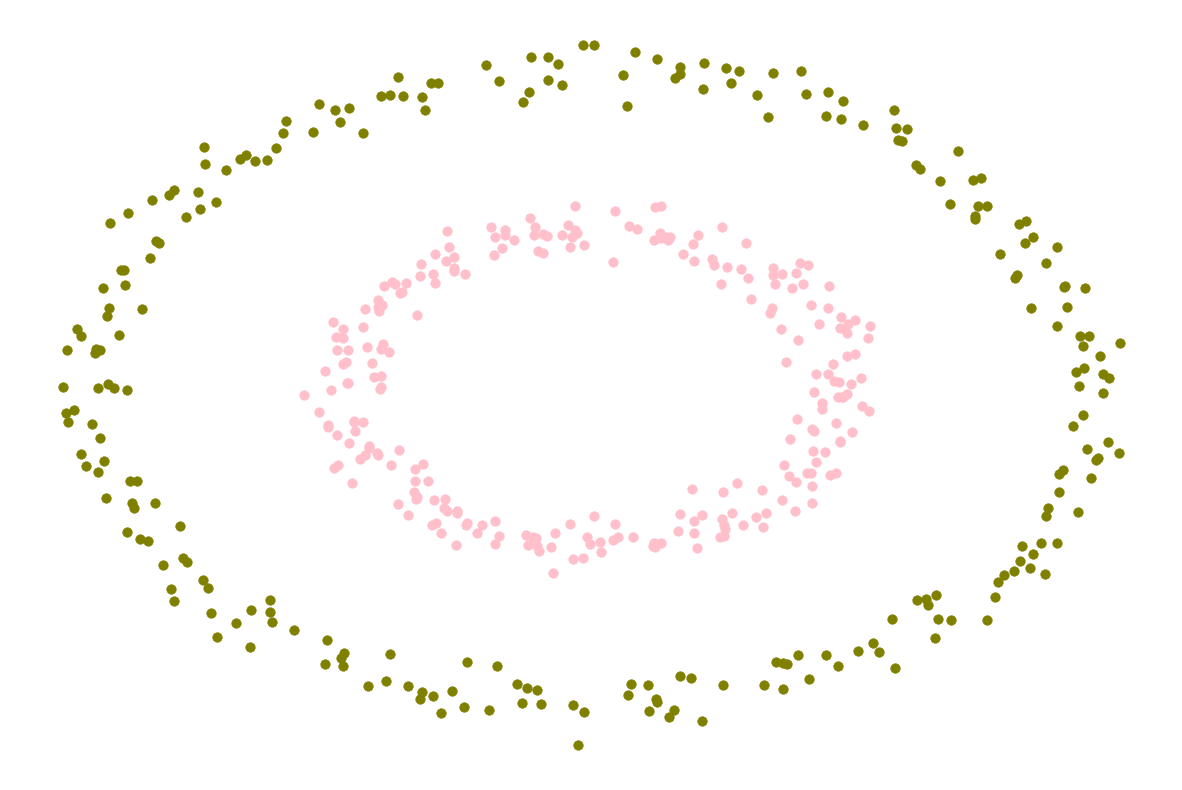

In [37]:
# Compute clusters 
clusters_2circles, _ = NNVR_clus( data_2circles, alpha = 20, persistence_threshold= p_thres_2circles, flag_eudist= 1, flag_distancematrix= 0, save_persistencedf= 0, path="")

# Select colors
col = [ "pink", "olive", "darkblue", "brown"]

# Set plot environment and plot the clusters
plt.figure(figsize=(15, 10))
for i in range(len(clusters_2circles)):
    points = data_2circles[list(clusters_2circles[i]), :]
    plt.scatter(points[:, 0], points[:, 1], color = col[i])

plt.axis('off')
plt.show()

---

### <h3 style="text-align: center;">**Pollution Data Clustering**</h3> 

---

#### <code style="background:royalblue;color:black">**Preprocessing**</code>

In [39]:
ds = pd.read_csv(path + "/global air pollution dataset.csv")
ds.head(5)

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good


In [43]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country             23036 non-null  object
 1   City                23462 non-null  object
 2   AQI Value           23463 non-null  int64 
 3   AQI Category        23463 non-null  object
 4   CO AQI Value        23463 non-null  int64 
 5   CO AQI Category     23463 non-null  object
 6   Ozone AQI Value     23463 non-null  int64 
 7   Ozone AQI Category  23463 non-null  object
 8   NO2 AQI Value       23463 non-null  int64 
 9   NO2 AQI Category    23463 non-null  object
 10  PM2.5 AQI Value     23463 non-null  int64 
 11  PM2.5 AQI Category  23463 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.1+ MB


An initial inspection of the dataset reveals that around $\sim 400$ rows contain missing data in the *Country* column. Since these missing values make up a small percentage of the total rows, we decided, for simplicity, to remove these rows as we felt that this did not undermine the representativeness of the dataset.

In [42]:
# remove ~ 400 rows with missing data
clean_out = ds[ds['Country'].notnull() & ds['City'].notnull()] 
clean_out.to_csv('cleaned_data.csv', index=False)

In [45]:
# AQI Category conversion from categorical to labeled data
# higher values mean higher risk

clean_out["AQI Category"] = clean_out["AQI Category"].map({'Good':0,'Moderate':1,'Unhealthy for Sensitive Groups':2, 
                                                           'Unhealthy':3,'Very Unhealthy':4, 'Hazardous':5})

clean_out["CO AQI Category"] = clean_out["CO AQI Category"].map({'Good':0,'Moderate':1,'Unhealthy for Sensitive Groups':2})

clean_out["Ozone AQI Category"] = clean_out["Ozone AQI Category"].map({'Good':0,'Moderate':1,'Unhealthy for Sensitive Groups':2, 
                                                                  'Unhealthy':3,'Very Unhealthy':4})

clean_out["NO2 AQI Category"] = clean_out["NO2 AQI Category"].map({'Good':0,'Moderate':1})

clean_out["PM2.5 AQI Category"] = clean_out["PM2.5 AQI Category"].map({'Good':0,'Moderate':1,'Unhealthy for Sensitive Groups':2, 
                                                           'Unhealthy':3,'Very Unhealthy':4, 'Hazardous':5})

#### <code style="background:royalblue;color:black">**Geolocalization of cities for visualization**</code>

In order to represent future clusters on a geographical map, we decided to extract and add the latitude and longitude coordinates of each city present to the dataset. This operation was automated using the `geo_lat_long` function, which uses the `geopy` library to retrieve this information from the city name and country already present in our data.

In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises") # Initialize the geolocator Nominatim

# Function to get latitude and longitude using geocode
def get_lat_long(city, country): 
    try:
        location = geolocator.geocode(f"{city}, {country}")
        return location.latitude, location.longitude
    except:
        return None, None

geocode = RateLimiter(get_lat_long, min_delay_seconds=1) # Apply rate limiter for API purposes

# Create new columns for latitude and longitude
clean_out[['Latitude', 'Longitude']] = clean_out.apply(lambda x: pd.Series(geocode(x['City'], x['Country'])), axis=1)

# since the API didn't recognize every city in our dataset, we removed some observations while keeping
# the non-null elemnents

In [53]:
# Save the new dataset into a .csv file
clean_out.to_csv('final_data.csv', index=False) 

#### <code style="background:royalblue;color:black">**Dimensionality reduction**</code>  

Since qualitative variables are not practical for the use of many of the clustering algorithms, we decided to work only on quantitative ones. First, we decided to check the correlation in order to see if it was possible to exclude linearly dependent columns. From inspection of the graph below, it is clear that `AQI Value` and `PM2.5 AQI Value` contain almost the same information, so we decided to remove the second of the two variables. 

In [2]:
# Load the new Dataset
df = pd.read_csv(path + "/final_data.csv")

# Extraction of the quantitative columns
quantitative_df = df[['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']]

df.head(5)

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,Latitude,Longitude
0,India,Phulabani,161,3,2,0,71,1,0,0,161,3,20.507566,84.227311
1,Poland,Piaseczno,28,0,1,0,28,0,2,0,28,0,52.074738,21.027089
2,India,Pimpri,118,2,2,0,30,0,2,0,118,2,18.623185,73.801993
3,Brazil,Pindobacu,33,0,0,0,10,0,1,0,33,0,-10.743912,-40.361946
4,China,Pingyin,150,3,3,0,95,1,6,0,150,3,36.289438,116.450321


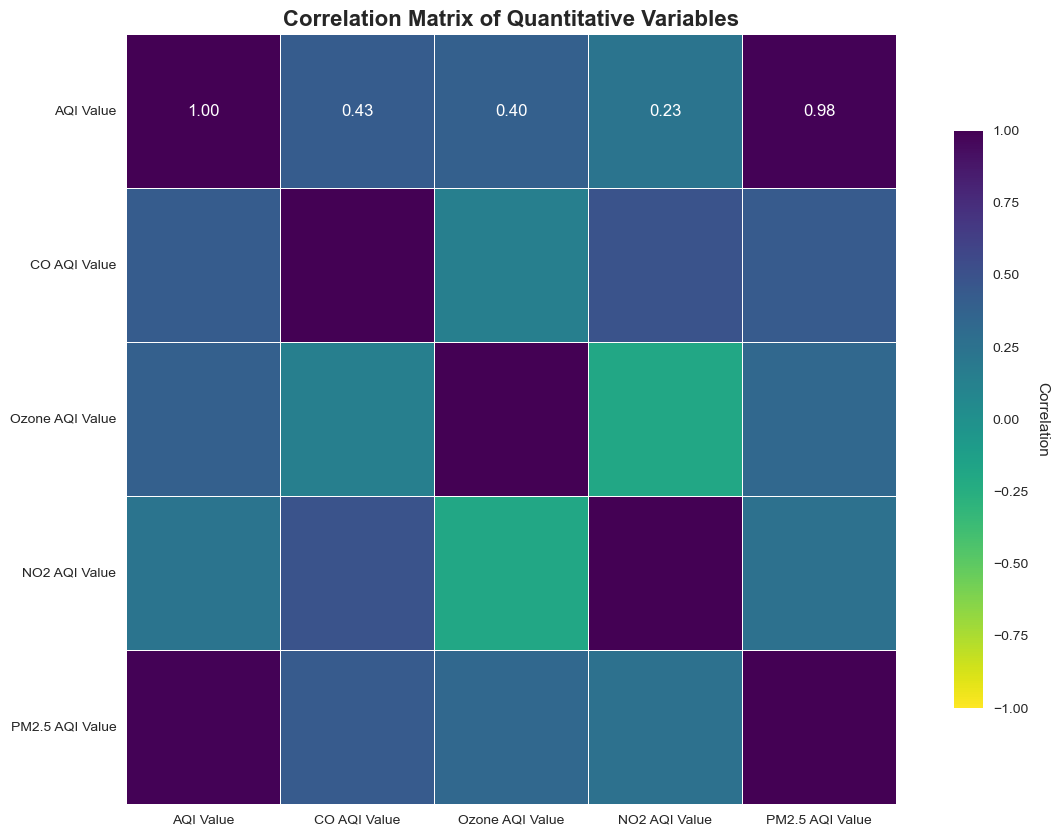

In [3]:
# Increase the size of the plot
plt.figure(figsize=(15, 10))

# Plot the correlation matrix with a specified color map
heatmap = sns.heatmap(quantitative_df.corr(), linewidths=0.5, vmin=-1, vmax=1, square=True,
                      cmap="viridis_r", linecolor='white', annot=True, fmt=".2f", cbar_kws={"shrink": 0.75})

plt.yticks(rotation=0)

# Customize the color bar using the mappable object from the heatmap
cbar = heatmap.collections[0].colorbar
cbar.set_label('Correlation', rotation=270, labelpad=15)

# Add a title
plt.title('Correlation Matrix of Quantitative Variables', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

We then tried to perform a dimensional reduction via **PCA** to see if it was possible to maintain a high variability with fewer columns. From reading the scree plot and the table below, it is clear that by selecting $3$ principal components we are able to maintain practically all the original variability present in the dataset (about $\sim 90 \%$) with the advantage that now, by reducing the size by $1$, we can also represent the 3D scatterplot of the points.

In [4]:
quantitative_df = df[['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value']]

# Create a PCA model with the 'prince' package
pca = PCA(
    n_components=4,             # Extract all the principal components (PC) --> to choose the optimal value based on the Scree Plot
    n_iter=3,                   # Number of iterations for the power method to compute eigenvectors
    rescale_with_mean=True,     # Rescale the data by subtracting the mean
    rescale_with_std=True,      # Rescale the data by dividing by the standard deviation
    copy=True,                  # Use a copy of the dataset in order to prevent side-effects on the input data
    check_input=True,           # Check the consistency of the dataset --> for istance: dtype, non-empty, etc.
    engine='sklearn',           # PCA algorithm engine 
    random_state=30             # Seed for reproducibility of the result since the prince package use a randomised version of SVD 
                                # which is faster than the standard SVD
)

# Fit the PCA model to the quantitative dataset
pca = pca.fit(quantitative_df)

# Print a summary of the eigenvalues
pca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.828,45.70%,45.70%
1,1.274,31.86%,77.56%
2,0.483,12.07%,89.63%
3,0.415,10.37%,100.00%


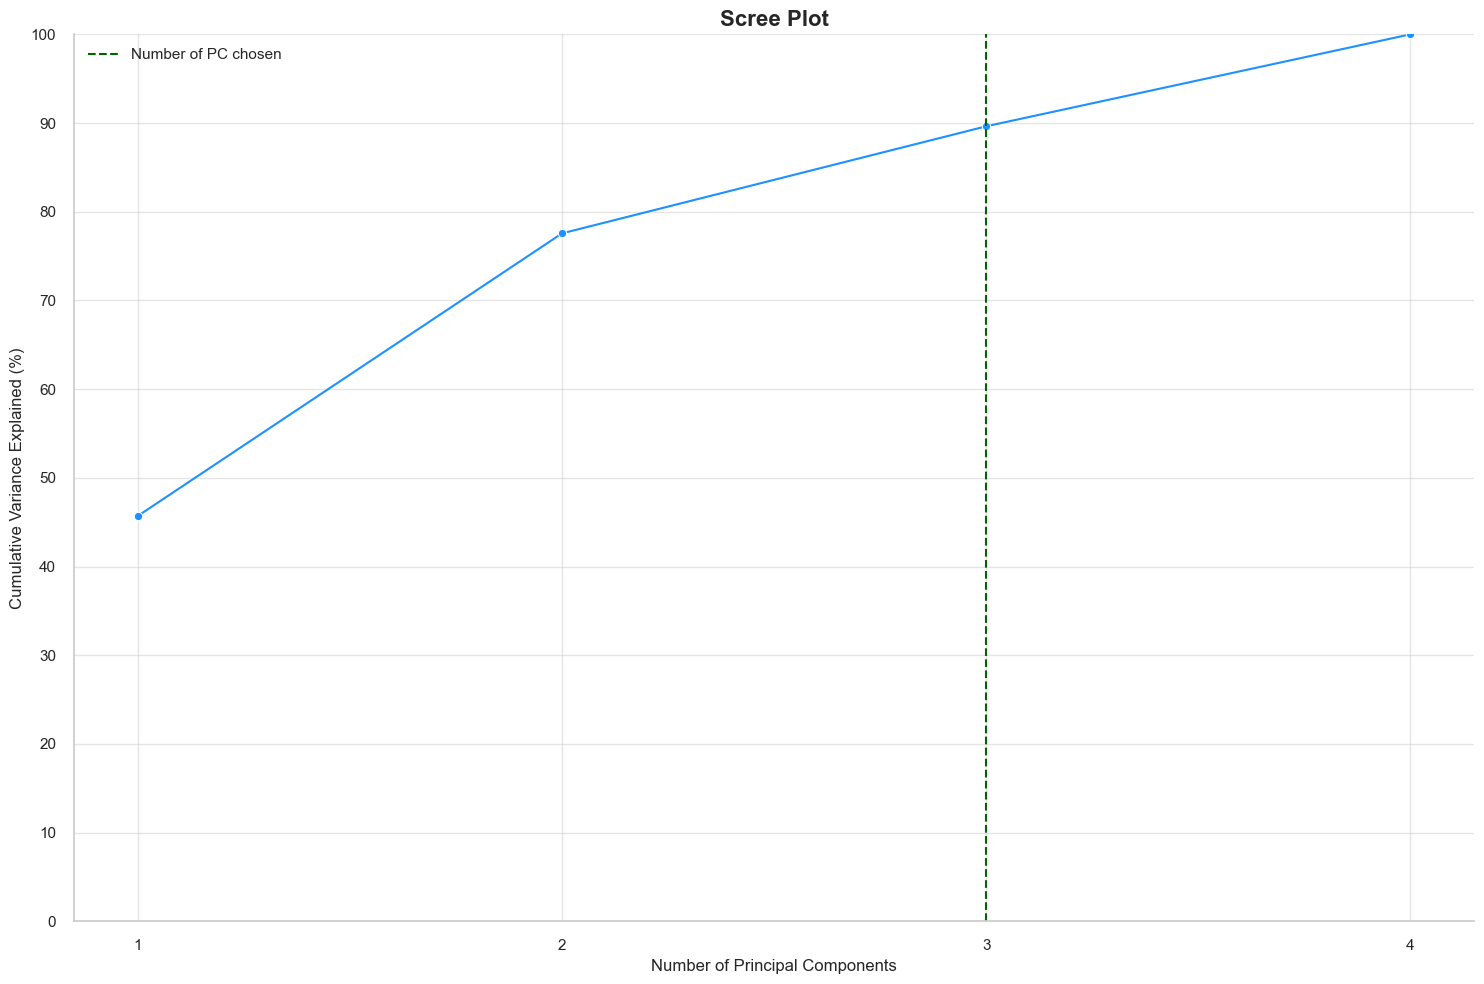

In [5]:
# Set the dimensions of the plot
plt.figure(figsize=(15, 10))

# Create the axis values of the plot
xi = np.arange(1, 5)
y = pca.cumulative_percentage_of_variance_

# Set the plot
sns.set(style="whitegrid")
sns.lineplot(x=xi, y=y, marker='o', color='dodgerblue')
plt.xlabel('Number of Principal Components')
plt.xticks(np.arange(1, 5, step=1))
plt.ylabel('Cumulative Variance Explained (%)')
plt.title('Scree Plot', fontsize=16, fontweight='bold')
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, step=10))

# Add a light grid
plt.grid(alpha=0.5)

plt.axvline(x=3, color='darkgreen', linestyle='--', label='Number of PC chosen')
plt.legend()

# Remove top and right borders
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

Once the dimension reduction was performed, we checked the communalities of each column in the original dataset and from reading the table below, we can state that each variable is well represented by the chosen principal components.

In [6]:
# Create a PCA model with the 'prince' package
pca = PCA(
    n_components=3,             # Extract the first 3 principal components (PC) [optimal choice]
    n_iter=3,                   # Number of iterations for the power method to compute eigenvectors
    rescale_with_mean=True,     # Rescale the data by subtracting the mean
    rescale_with_std=True,      # Rescale the data by dividing by the standard deviation
    copy=True,                  # Use a copy of the dataset in order to prevent side-effects on the input data
    check_input=True,           # Check the consistency of the dataset --> for istance: dtype, non-empty, etc.
    engine='sklearn',           # PCA algorithm engine 
    random_state=30             # Seed for reproducibility of the result since the prince package use a randomised version of SVD 
                                # which is faster than the standard SVD
)
# Fit the PCA model to the quantitative dataset
pca = pca.fit(quantitative_df)

# Calculate communalities as the sum of squared column coordinates
communalities = (pca.column_coordinates_ ** 2).sum(axis=1)

# Create a DataFrame to visualize the results
communalities_df = pd.DataFrame(index=quantitative_df.columns, data={'Communality': communalities})

# Sort the DataFrame in descending order of Communality
communalities_df = communalities_df.sort_values(by='Communality', ascending=False).reset_index()

# Rename the index as Variable
communalities_df = communalities_df.rename(columns={'index': 'Variable'})

# Plot the Communalities
communalities_df

,Variable,Communality
0,AQI Value,0.978955
1,Ozone AQI Value,0.899498
2,CO AQI Value,0.892754
3,NO2 AQI Value,0.814032


Since each Principal Component is an index of the original variables, we have returned the *Factor pattern* to be able to interpret its scores.

In [7]:
# Factor pattern
round(pca.column_correlations, 2)

component,0,1,2
variable,,,
AQI Value,0.78,-0.34,-0.50
CO AQI Value,0.83,0.20,0.40
Ozone AQI Value,0.38,-0.83,0.26
NO2 AQI Value,0.62,0.65,-0.06


In [8]:
# Obtain the PCA dataset
pca_df = pca.fit_transform(quantitative_df)

# Rename the PC
pca_df = pca_df.rename(columns={0: 'PC 1', 1: 'PC 2', 2: 'PC 3'})
pca_df.columns.name = None

# Save the PCA dataset
pca_df.to_csv('pca_df.csv', index=False)

pca_df.head(5)

,PC 1,PC 2,PC 3
0,1.217410,-1.714873,-0.425560
1,-0.738527,0.254425,0.373122
2,0.537267,-0.176782,-0.450788
3,-1.284331,0.501093,-0.225943
4,2.194101,-1.542666,0.255769


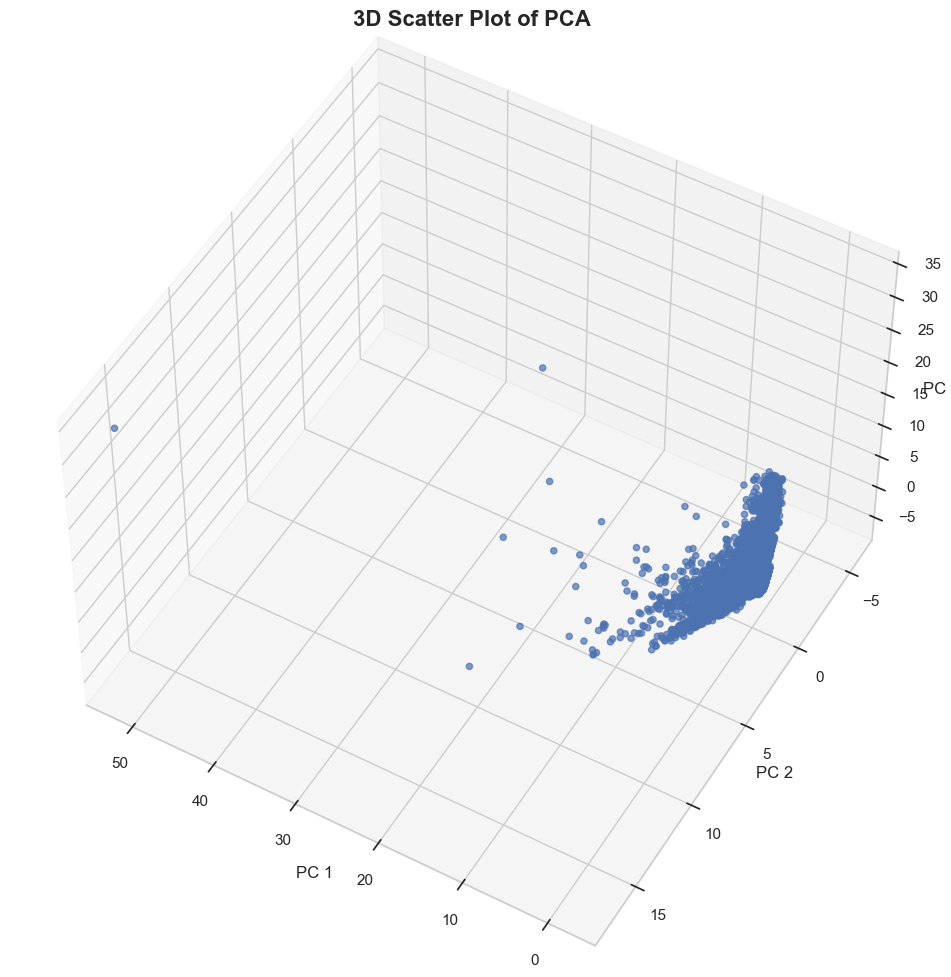

In [110]:
# Extract the principal components
x = pca_df.iloc[:, 0]
y = pca_df.iloc[:, 1]
z = pca_df.iloc[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, cmap='viridis', marker='o', alpha=0.7)

# Set the labels for the axes
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# Set the title
plt.title('3D Scatter Plot of PCA', fontsize=16, fontweight='bold')

# Set the perspective of the plot
ax.view_init(elev=50, azim=120)

# Show the plot
plt.show()

<code style="background:darkred;color:black">**Important note:**</code>  

Given the distribution of points in the scatterplot we immediately notice that the datapoints are very dense which, we believe, will make it difficult to distinguish clusters representative of the various air qualities. Given this issue we expect that our benchmark metric for cluster goodness, namely the silhouette score, will tend to prefer a very low number of clusters in which one of them will probably contain almost all of our datapoints. Given these considerations, our choice of parameters for the various algorithms will mainly be influenced by a graphical inspection of the scatterplot (appropriately coloured according to the cluster) to see whether the result obtained contains an acceptable number of sufficiently numerous clusters.

#### <code style="background:royalblue;color:black">**NNVR-filtration based Clustering**</code>  

In [59]:
# Convert pandas dataframe to numpy array
pca_np = np.array(pca_df)

# Compute distances between couple of points
d_pca = eu_dist(pca_np, flag = 1) # The maximum value is sligthly above 62

In [ ]:
# Compute NNVR filtration of the whole
nnvr_airpoll_out = NNVR_fromdistance(d_pca, 65)

100%|██████████| 247886053/247886053 [4:23:56<00:00, 15653.10it/s]  


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

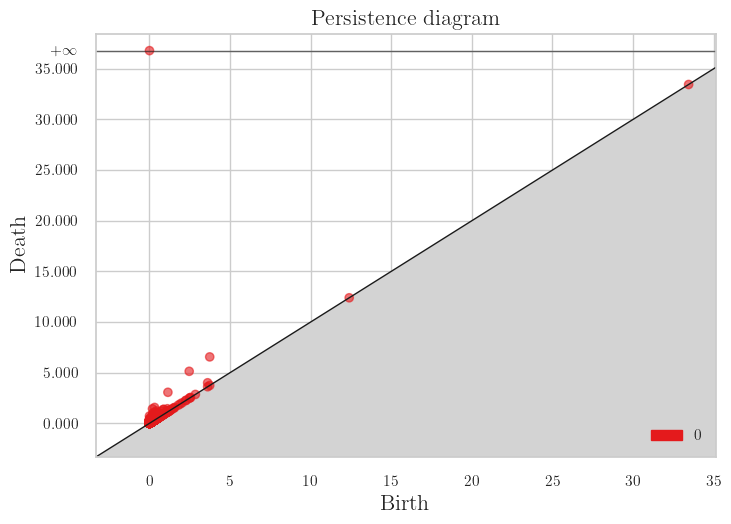

In [ ]:
# Compute persistence barcode and plot the persistence diagram
bcodes_airpoll_out = nnvr_airpoll_out.persistence(min_persistence=-1) # Output: list of ( dim, (birth, death) )
gd.plot_persistence_diagram(bcodes_airpoll_out)

In [ ]:
# Extract birth times, death times and compute persistence
birth_times = np.array([el[1][0] for el in bcodes_airpoll_out])
death_times = np.array([el[1][1] for el in bcodes_airpoll_out])
persist = death_times - birth_times

# Compute birth threshold and persitence threshold
birth_threshold = maxjump(birth_times)
pers_threshold = maxjump(persist[1:])

print("Birth threshold:", birth_threshold, "Persistence threshold:", pers_threshold)

Birth threshold: 10.527426051421184 Persistence threshold: 0.37521699113508955


The birth threshold we obtain using *maxjump* seems reasonable. On the other hand, although the scale of the graph prevents us from having a clear idea of the number of clusters we will get, the persistence threshold seems to be too low compared to the number of clusters we expect to have. In fact, since the AQI has 5 categories, it seems reasonable to us to get a number of clusters that varies between 3 and 6.

In [66]:
# Find the outliers 
outliers_airpoll = get_outliers(d_pca, birth_threshold)
print("The outliers detected have as indeces:", outliers_airpoll)

# Create a new dataframe excluding the outliers
data_no_outliers = pca_df.drop(list(outliers_airpoll)).reset_index(drop = True)

# Compute the distance matrix of the points without the outliers
d_pca_no_outliers = eu_dist(np.array(data_no_outliers), flag = 1) # The maximum value is in [26, 27]

The outliers detected have as indeces: {4841, 10771}


In [ ]:
# Specify path to save the dataframe containing persistence information
path_noout = path + "/df_persistence_airpoll_no_outliers.csv"

# Compute the clusters 
clusters_pca_no_out, NNVR_airpoll_noout  = NNVR_clus(d_pca_no_outliers, alpha= 30, persistence_threshold= pers_threshold, flag_eudist=1, flag_distancematrix=1, save_persistencedf = 1, path= path_noout )

Constructing NNVR filtration...


100%|██████████| 247841524/247841524 [5:26:01<00:00, 12669.96it/s]  


Retrieving persistence infromation
Computing clusters ...


100%|██████████| 22264/22264 [00:00<00:00, 72930.52it/s]


In [ ]:
# See how many clusters we have
len(clusters_pca_no_out)

29

As expected, the persistence threshold found is way too low, leaving us with 29 clusters. For this reason, we decided not to show the results obtained with this non-parametric version of the algorithm, but to set a persistence threshold ourselves while exploiting our pevious knowledge on the data. This of course makes the algorithm parametric (the persistence threshold becomes a parameter that has to be chosen), but this way we hope to obtain results that are at least acceptable.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

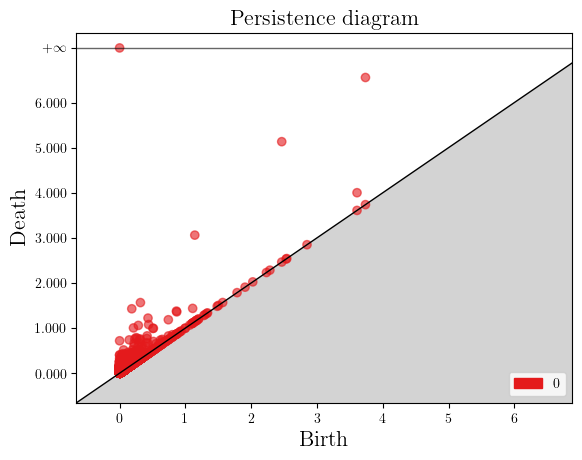

In [ ]:
# Plot persistence diagram of the NNVR filtration excluding the outliers
gd.plot_persistence_diagram(NNVR_airpoll_noout.persistence(min_persistence=-1))

As said before, we expect a number of cluster that is between 3 and 6 (which correspond to the number of different AQI categories). Looking at the persistence diagram above, we can say that this threshold is between 1 and 2, so we're gonna try some different values of the threshold to see which one gives the best results. 

In [81]:
# Persistence dataframe path (without outliers)
persistence_df_airpoll_path = "df_persistence_airpoll_no_outliers.csv"
persistence_df_airpoll = pd.read_csv(persistence_df_airpoll_path)

# Select only the needed columns and 
persistence_df_airpoll = persistence_df_airpoll[["BS", "DS", "BT", "DT", "Persistence"]]
persistence_df_airpoll["DS"] = persistence_df_airpoll.DS.apply(lambda el: ast.literal_eval(el))
persistence_df_airpoll["BS"] = persistence_df_airpoll.BS.apply(lambda el: ast.literal_eval(el))

# Set the threshold
pers_threshold_airpoll = 1

# Compute clusters
clusters_airpoll = NNVR_clusters_from_dataframe(persistence_df= persistence_df_airpoll, persistence_threshold= pers_threshold_airpoll)
print("The number of clusters you obtained is:", len(clusters_airpoll))


The number of clusters you obtained is: 6


Since the number of clusters obtained is good, we're going to extract the labels of the clusters, compute the silhouette score and visualize the results.

In [82]:
# Get the clusters labels
n_samples_noout = len(data_no_outliers)
cluster_labels_airpoll = [None] * n_samples_noout 

for label in range(len(clusters_airpoll)): 
    cluster = clusters_airpoll[label]
    for point in cluster:
        cluster_labels_airpoll[point] = label

# Compute the Shilouette score of the clusters
print("The Silhouette score is:", silhouette_score(data_no_outliers, cluster_labels_airpoll))


The Silhouette score is: 0.7933992072276506


Since the results obtained by forcing the 6 clustern are not visually satisfactory (see geo-visualisation), we tried to see in the 3D scatterplot what would come out with the original *maxjump* threshold.

In [95]:
# Set the threshold
pers_threshold_airpoll = 0.37521699113508955

# Compute clusters
clusters_airpoll = NNVR_clusters_from_dataframe(persistence_df= persistence_df_airpoll, persistence_threshold= pers_threshold_airpoll)
print("The number of clusters you obtained is:", len(clusters_airpoll))

# Get the clusters labels
n_samples_noout = len(data_no_outliers)
cluster_labels_airpoll = [None] * n_samples_noout 

for label in range(len(clusters_airpoll)): 
    cluster = clusters_airpoll[label]
    for point in cluster:
        cluster_labels_airpoll[point] = label

# Compute the Shilouette score of the clusters
print("The Silhouette score is:", silhouette_score(data_no_outliers, cluster_labels_airpoll))


The number of clusters you obtained is: 29
The Silhouette score is: 0.44280031810392073


In [ ]:
airpoll_clus = data_no_outliers.copy()
airpoll_clus.insert(0, "Cluster", cluster_labels_airpoll)

pca_3d_scatterplot(airpoll_clus, plot_name='NNVR_cluster_pca.html')

If we go to the plot file, we can see that also in this case the results aren't good since there's a big cluster containg almost all the points, while the other clusters seem to capture noise and not real clusters.

#### <code style="background:royalblue;color:black">**Hierarchical Clustering - Ward distance**</code>  

In [73]:
results = []

for k in range(3,7):
    # Perform a hierarchical clustering untill we have k number of cluster (Ward distance)
    ward = AgglomerativeClustering(n_clusters=k, linkage="ward").fit(pca_df)
    labels = ward.labels_

    # Calculus of the silhouette score
    score = silhouette_score(pca_df, labels)

    # Add the results to the list
    results.append({"k": k, "silhouette_score": score})

# Ceate a pandas dataframe of the results
pd.DataFrame(results)

,k,silhouette_score
0,3,0.613523
1,4,0.584541
2,5,0.583987
3,6,0.416911


In [111]:
ward = AgglomerativeClustering(n_clusters=6, linkage="ward").fit(pca_df)
# Label extraction
ward_labels = ward.labels_

In [112]:
# Add the cluster labels to the PCA dataset
ward_data = pca_df.copy()
ward_data.insert(0, 'Cluster', ward_labels)

# Add the useful columns for the geolocalization plot to the dataset
ward_data.insert(4, 'Country', df['Country'])
ward_data.insert(5, 'City', df['City'])
ward_data.insert(6, 'Latitude', df['Latitude'])
ward_data.insert(7, 'Longitude', df['Longitude'])

ward_data.head(5)

,Cluster,PC 1,PC 2,PC 3,Country,City,Latitude,Longitude
0,0,1.217410,-1.714873,-0.425560,India,Phulabani,20.507566,84.227311
1,2,-0.738527,0.254425,0.373122,Poland,Piaseczno,52.074738,21.027089
2,5,0.537267,-0.176782,-0.450788,India,Pimpri,18.623185,73.801993
3,2,-1.284331,0.501093,-0.225943,Brazil,Pindobacu,-10.743912,-40.361946
4,0,2.194101,-1.542666,0.255769,China,Pingyin,36.289438,116.450321


In [113]:
# Extract the cardinality of each cluster
cluster_cardinality(ward_data)

,Cluster Label,Number of Points
0,Noise,0
1,0,1613
2,1,78
3,2,15702
4,3,727
5,4,1347
6,5,2799


In [114]:
pca_3d_scatterplot(ward_data, plot_name='ward_interactive_plot.html')

#### <code style="background:royalblue;color:black">**K-means**</code>  

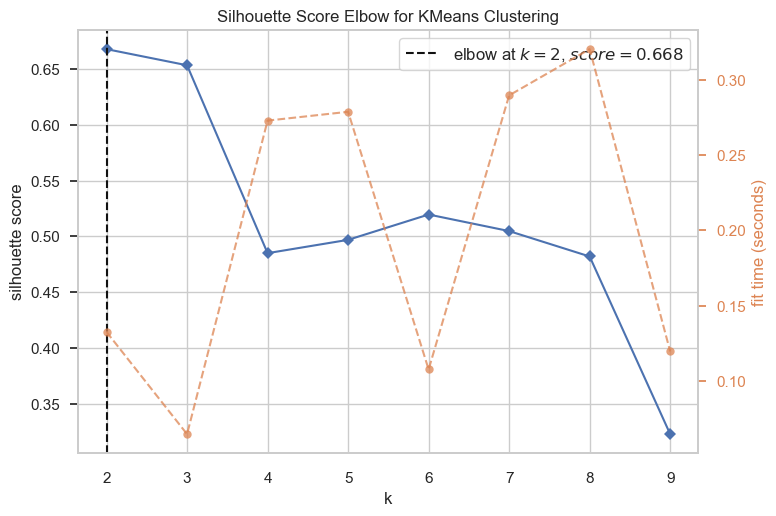

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [17]:
# Plot the Silhouette Score for a number of cluster that goes from 2 to 9
visualizer = KElbowVisualizer(KMeans(n_init='auto'), k = (2, 10), timings = True, metric = "silhouette")
visualizer.fit(pca_df)
visualizer.show()

In [115]:
# Execution of the k-means clustering
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(pca_df)
# Label extraction
k_labels = kmeans.labels_

In [116]:
# Add the Cluster column to the dataset 
k_means_data = pca_df.copy()
k_means_data.insert(0, 'Cluster', k_labels)
# Add the useful columns for the geolocalization plot to the dataset
k_means_data.insert(4, 'Country', df['Country'])
k_means_data.insert(5, 'City', df['City'])
k_means_data.insert(6, 'Latitude', df['Latitude'])
k_means_data.insert(7, 'Longitude', df['Longitude'])

k_means_data.head(5)

,Cluster,PC 1,PC 2,PC 3,Country,City,Latitude,Longitude
0,5,1.217410,-1.714873,-0.425560,India,Phulabani,20.507566,84.227311
1,4,-0.738527,0.254425,0.373122,Poland,Piaseczno,52.074738,21.027089
2,0,0.537267,-0.176782,-0.450788,India,Pimpri,18.623185,73.801993
3,4,-1.284331,0.501093,-0.225943,Brazil,Pindobacu,-10.743912,-40.361946
4,1,2.194101,-1.542666,0.255769,China,Pingyin,36.289438,116.450321


In [117]:
# Extract the cardinality of each cluster
cluster_cardinality(k_means_data)

,Cluster Label,Number of Points
0,Noise,0
1,0,7290
2,1,961
3,2,264
4,3,2306
5,4,10129
6,5,1316


In [118]:
# Save a .html with a interactive 3D scatterplot
pca_3d_scatterplot(k_means_data, plot_name='k_means_interactive_plot.html')

#### <code style="background:royalblue;color:black">**Optics**</code>  

In [46]:
# Extract the optics structure
optics_model = OPTICS(min_samples=50, cluster_method='dbscan')
optics_model.fit(pca_df)

OPTICS(cluster_method='dbscan', min_samples=50)

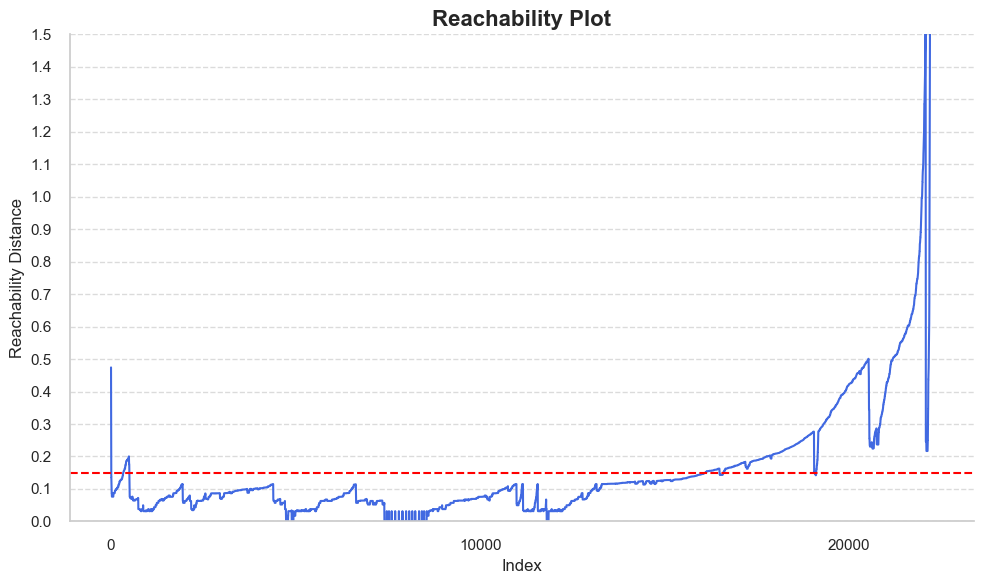

In [47]:
# Extract the data point in the order into the reachability plot
order = optics_model.ordering_

# Extract the reachability distance in the correct order for the plot
reachability = optics_model.reachability_[order]

# Creation of a matrix with the reachability distance for each datapoint
reach_matrix = pd.DataFrame({
    'Index': np.arange(1, len(order) + 1),
    'Reachability': reachability
})

# Set the dimension of the plot
plt.figure(figsize=(10, 6))

# Plot creation and graphic settings
sns.set(style="whitegrid")
sns.lineplot(x=reach_matrix['Index'], y=reach_matrix['Reachability'], color='royalblue')

# Horizontal threshold for the choosen epsilon 
plt.axhline(y=0.15, color='red', linestyle='--')

# Plot title and axis labels
plt.title('Reachability Plot', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=12)
plt.ylabel('Reachability Distance', fontsize=12)

# Truncate the y-axis for a better visualization of the plot core
plt.ylim(0, 1.5)

# Remove the vertical grid
plt.grid(axis='x', visible=False) 

# Set the horizontal grid and its graphic settings
plt.grid(axis='y', linestyle='--', alpha=0.7)  

# Set the axis scales
plt.yticks(np.arange(0, 1.6, 0.1))
plt.xticks(ticks=np.arange(0, len(order)+1, 10000))

# Remove the upper and right margin
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

In [48]:
# Perform a DBSCAN clustering with the chosen epsilon value
optics_labels = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=0.15,
)

# Add the cluster labels to the PCA dataset
optics_data = pca_df.copy()
optics_data.insert(0, 'Cluster', optics_labels)

# Add the useful columns for the geolocalization plot to the dataset
optics_data.insert(4, 'Country', df['Country'])
optics_data.insert(5, 'City', df['City'])
optics_data.insert(6, 'Latitude', df['Latitude'])
optics_data.insert(7, 'Longitude', df['Longitude'])

optics_data.head(5)

,Cluster,PC 1,PC 2,PC 3,Country,City,Latitude,Longitude
0,-1,1.217410,-1.714873,-0.425560,India,Phulabani,20.507566,84.227311
1,1,-0.738527,0.254425,0.373122,Poland,Piaseczno,52.074738,21.027089
2,-1,0.537267,-0.176782,-0.450788,India,Pimpri,18.623185,73.801993
3,1,-1.284331,0.501093,-0.225943,Brazil,Pindobacu,-10.743912,-40.361946
4,-1,2.194101,-1.542666,0.255769,China,Pingyin,36.289438,116.450321


In [49]:
# Extract the cardinality of each cluster
cluster_cardinality(optics_data)

,Cluster Label,Number of Points
0,Noise,6175
1,0,329
2,1,15605
3,2,106
4,3,51


In [83]:
# Shilouette score of the clusters
silhouette_score(pca_df, optics_labels)

0.11802332470549808

In [84]:
# Save a .html with a interactive 3D scatterplot
pca_3d_scatterplot(optics_data, plot_name='optics_interactive_plot.html')

#### <code style="background:royalblue;color:black">**H-DBSCAN**</code>  

In [64]:
# Perform an automatic grid search to find the best parameters (based on the silhouette score) that returns a number of clusters into a valid range (min number of valid cluster = 3)
# NOTE: in this function the 'min_cluster_size' and the 'min_samples' parameters are the max value of that parameter into the grid search (min = 5 and step = 10)
result = find_best_hdbscan_params(pca_df, min_cluster_size=200, min_samples=200, max_clusters=6)

# these are the optimal parameters and the corresponding silhouette score for the valid cluster size possible into the grid 
pd.DataFrame(result)

,4,3
0,"(5, 105)","(5, 155)"
1,0.387017,0.384072


In [119]:
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=155)
hdbscan_model.fit(pca_df)

# Label extraction
h_dbscan_label = hdbscan_model.labels_

In [120]:
# Add the cluster labels to the PCA dataset
h_dbscan_data = pca_df.copy()
h_dbscan_data.insert(0, 'Cluster', h_dbscan_label)

# Add the useful columns for the geolocalization plot to the dataset
h_dbscan_data.insert(4, 'Country', df['Country'])
h_dbscan_data.insert(5, 'City', df['City'])
h_dbscan_data.insert(6, 'Latitude', df['Latitude'])
h_dbscan_data.insert(7, 'Longitude', df['Longitude'])

h_dbscan_data.head(5)

,Cluster,PC 1,PC 2,PC 3,Country,City,Latitude,Longitude
0,-1,1.217410,-1.714873,-0.425560,India,Phulabani,20.507566,84.227311
1,1,-0.738527,0.254425,0.373122,Poland,Piaseczno,52.074738,21.027089
2,-1,0.537267,-0.176782,-0.450788,India,Pimpri,18.623185,73.801993
3,1,-1.284331,0.501093,-0.225943,Brazil,Pindobacu,-10.743912,-40.361946
4,-1,2.194101,-1.542666,0.255769,China,Pingyin,36.289438,116.450321


In [121]:
# Extract the cardinality of each cluster
cluster_cardinality(h_dbscan_data)

,Cluster Label,Number of Points
0,Noise,4766
1,0,444
2,1,16691
3,2,365


In [122]:
pca_3d_scatterplot(h_dbscan_data, plot_name='h_dbscan_interactive_plot.html')

#### <code style="background:royalblue;color:black">**Mean-Shift**</code>  

In [123]:
# Mean Shift Clustering forcing few clusters

# Estimate bandwidth
bandwidth2 = estimate_bandwidth(pca_df, quantile= 0.2, n_samples=500)

# Perform Mean Shift clustering
ms = MeanShift(bandwidth=bandwidth2, bin_seeding=True)

# Label extraction
ms_labels=ms.fit_predict(pca_df)

In [124]:
# Add the cluster labels to the PCA dataset
ms_data = pca_df.copy()
ms_data.insert(0, 'Cluster', ms_labels)

# Add the useful columns for the geolocalization plot to the dataset
ms_data.insert(4, 'Country', df['Country'])
ms_data.insert(5, 'City', df['City'])
ms_data.insert(6, 'Latitude', df['Latitude'])
ms_data.insert(7, 'Longitude', df['Longitude'])

ms_data.head(5)

,Cluster,PC 1,PC 2,PC 3,Country,City,Latitude,Longitude
0,0,1.217410,-1.714873,-0.425560,India,Phulabani,20.507566,84.227311
1,0,-0.738527,0.254425,0.373122,Poland,Piaseczno,52.074738,21.027089
2,0,0.537267,-0.176782,-0.450788,India,Pimpri,18.623185,73.801993
3,0,-1.284331,0.501093,-0.225943,Brazil,Pindobacu,-10.743912,-40.361946
4,1,2.194101,-1.542666,0.255769,China,Pingyin,36.289438,116.450321


In [125]:
# Extract the cardinality of each cluster
cluster_cardinality(ms_data)

,Cluster Label,Number of Points
0,Noise,0
1,0,20126
2,1,960
3,2,93
4,3,487
5,4,41
6,5,21
7,6,11
8,7,26
9,8,6


In [126]:
# Shilouette score of the clusters
silhouette_score(pca_df, ms_labels)

0.5363585713625542

In [127]:
pca_3d_scatterplot(ms_data, plot_name='ms_interactive_plot.html')

#### <code style="background:royalblue;color:black">**Spectral**</code>  

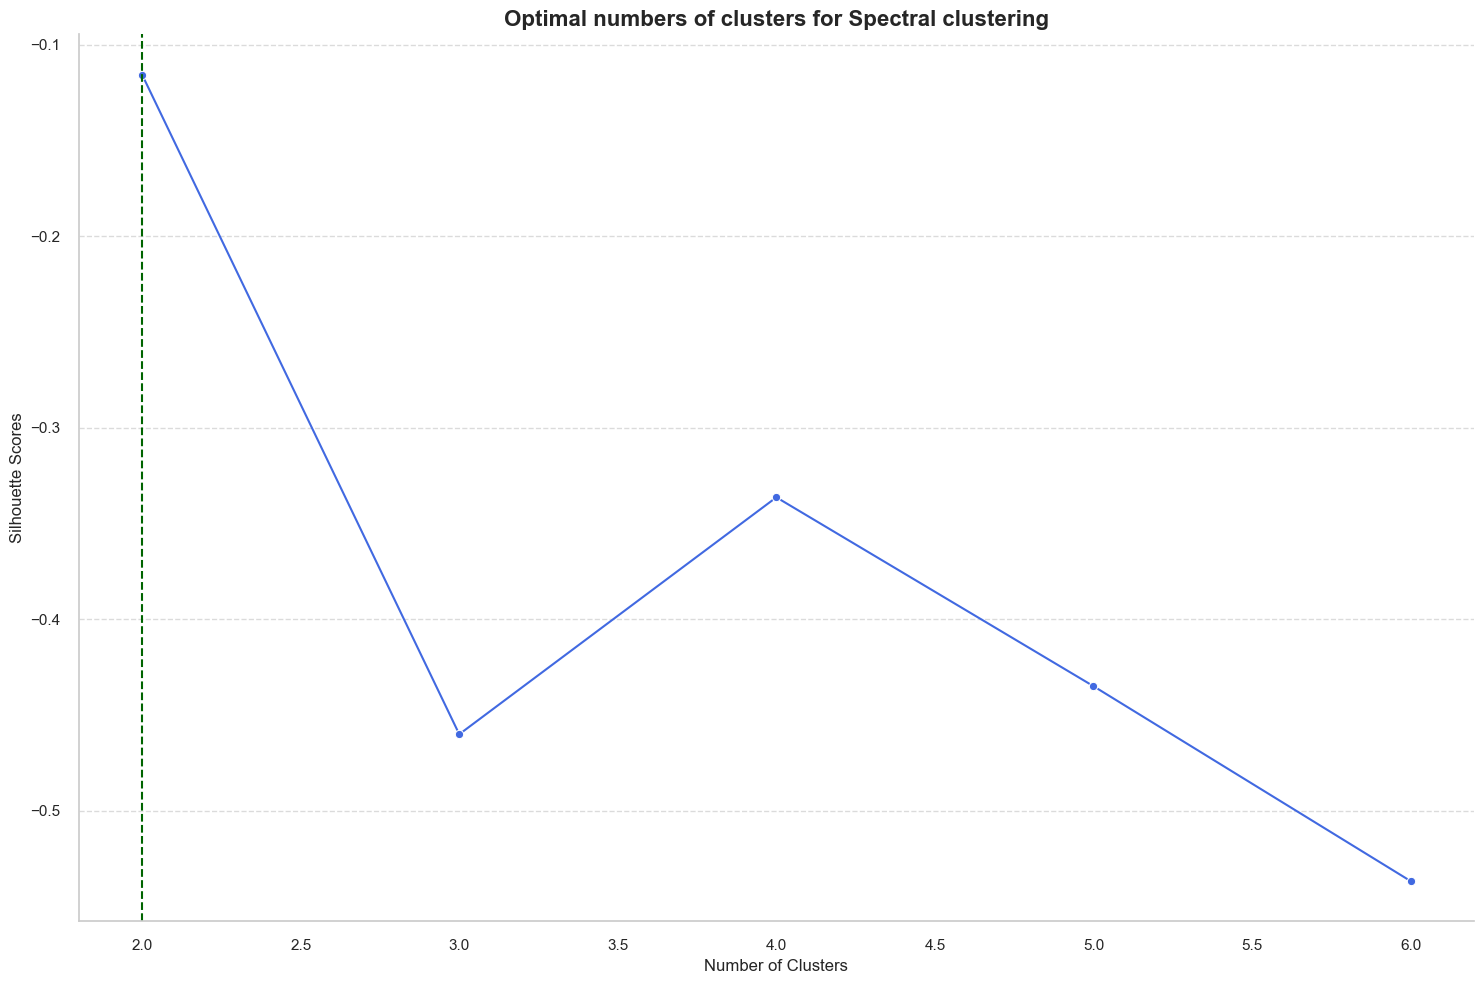

In [96]:
# Selection of the optimal number of cluster based on the Silhouette score
find_best_spectral_params(pca_df, max_clusters=6)

In [128]:
spectral = SpectralClustering(n_clusters=6, affinity='nearest_neighbors', random_state=12)
# Label extraction
sc_labels = spectral.fit_predict(pca_df)

In [129]:
# Add the cluster labels to the PCA dataset
spectral_data = pca_df.copy()
spectral_data.insert(0, 'Cluster', sc_labels)

# Add the useful columns for the geolocalization plot to the dataset
spectral_data.insert(4, 'Country', df['Country'])
spectral_data.insert(5, 'City', df['City'])
spectral_data.insert(6, 'Latitude', df['Latitude'])
spectral_data.insert(7, 'Longitude', df['Longitude'])

spectral_data.head(5)

,Cluster,PC 1,PC 2,PC 3,Country,City,Latitude,Longitude
0,0,1.217410,-1.714873,-0.425560,India,Phulabani,20.507566,84.227311
1,0,-0.738527,0.254425,0.373122,Poland,Piaseczno,52.074738,21.027089
2,0,0.537267,-0.176782,-0.450788,India,Pimpri,18.623185,73.801993
3,0,-1.284331,0.501093,-0.225943,Brazil,Pindobacu,-10.743912,-40.361946
4,0,2.194101,-1.542666,0.255769,China,Pingyin,36.289438,116.450321


In [130]:
# Extract the cardinality of each cluster
cluster_cardinality(spectral_data)

,Cluster Label,Number of Points
0,Noise,0
1,0,22195
2,1,10
3,2,16
4,3,12
5,4,17
6,5,16


In [131]:
pca_3d_scatterplot(spectral_data, plot_name='spectral_interactive_plot.html')

---

### <h3 style="text-align: center;">**Clusters interpretation**</h3> 

---

We tested a large number of alternatives methods, choosing them from the ones use for comparison in the original paper. On this data some of them weren't able to recognize a reasonable number of reasonable sized clusters (meanshift and spectral), while some others gave very similar results(optics and HDBSCAN). 
We decided to plot and analyze further only the somewhat meaningful clusters we obtained.

In [98]:
# Standardization of the quantitative coluns 
# the standardized value are useful for a easier interpretation of the centroids
scaler = StandardScaler().fit_transform(quantitative_df)
scaler = pd.DataFrame(scaler)
scaler.columns = quantitative_df.columns

#### <code style="background:royalblue;color:black">**K-means**</code>  

In [100]:
k_centroids = scaler.copy()
k_centroids.insert(0, 'Cluster', k_labels)

round(k_centroids.groupby('Cluster').mean(),2)

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value
Cluster,,,,
0,-0.17,-0.14,0.25,-0.39
1,1.78,1.01,3.87,-0.10
2,2.08,5.06,-0.74,4.65
3,0.48,0.75,-0.63,1.81
4,-0.51,-0.29,-0.43,-0.20
5,2.27,-0.06,0.35,-0.36


The $6$ cluster we identified with k-means can be characterized as it follows:


- Cluster 0 $\to$ all values relatively close to the average; 
- Cluster 1 $\to$ high values for *Ozone* and relatively high value of *AQI value*;
- Cluster 2 $\to$ extremly high values of *CO* and *NO2* and high values for *AQI value*;
- Cluster 3 $\to$ also close to average, compared to cluster 1 it is almost specular, like if they described to kind of situation close to the average;
- Cluster 4 $\to$ low values for all the variables, this should be the cluster with the best air compared to others;
- Cluster 5 $\to$ high *AQI value*, relatively close to average concerning the other variables.

#### <code style="background:royalblue;color:black">**Hierarchical - Ward distance**</code>  

In [101]:
ward_centroids = scaler.copy()
ward_centroids.insert(0, 'Cluster', ward_labels)

round(ward_centroids.groupby('Cluster').mean(), 2)

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value
Cluster,,,,
0,2.10,0.09,0.71,-0.31
1,3.10,9.51,-0.83,5.69
2,-0.39,-0.27,-0.12,-0.35
3,1.74,0.99,4.31,-0.18
4,0.79,1.27,-0.74,2.79
5,0.08,0.31,-0.46,0.72


The $6$ cluster we identified with the hierarchical clustering can be characterized as it follows:

- Cluster 0 $\to$ high value for AQI, slightly above average ozone;
- Cluster 1 $\to$ extremely high CO values, high values for AQI and NO2;
- Cluster 2 $\to$ all values below average, this time this is the cluster of the city with the cleanest air;
- Cluster 3 $\to$ high value for ozone;
- Cluster 4 $\to$ high presence of NO2, above average presence of CO;
- Cluster 5 $\to$ all values very close to the average.

#### <code style="background:royalblue;color:black">**H-DBSCAN**</code>  

In [102]:
h_dbscan_centroids = scaler.copy()
h_dbscan_centroids.insert(0, 'Cluster', h_dbscan_label)

round(h_dbscan_centroids.groupby('Cluster').mean(),2)

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value
Cluster,,,,
-1,1.16,0.75,0.26,0.90
0,1.58,0.93,4.23,-0.30
1,-0.41,-0.24,-0.19,-0.24
2,1.53,-0.20,0.15,-0.56


The $3$ cluster we identified with the H-DBSCAN can be characterized as it follows:

- Cluster -1 $\to$ outliers 
- Cluster 0 $\to$ high values of ozone, relatively high AQI value and CO
- Cluster 1 $\to$ low values for all the variables
- Cluster 2 $\to$ high AQI value, close to the  average for the other variables

---

### <h3 style="text-align: center;">**Clusters Geo-Visualization**</h3> 

---

In [16]:
# Extraction of the location of the datapoint 
locations = df[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()

#### <code style="background:royalblue;color:black">**K-means**</code>  

In [ ]:
# Select whichever colors we want for the visualization
colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkblue']

# Map creation
map = folium.Map(location=[50,20], zoom_start=5, tiles="Cartodb dark_matter")

for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point],radius=0.5,color = colors[k_means_data["Cluster"].iloc[point]], popup=df["City"].iloc[point]).add_to(map)
    
# HTML code for the legend
legend_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 100px; height: 130px; 
            border:2px None; z-index:9999; font-size:14px;
            background-color: None; opacity: 1; color: white;">
&emsp;<i style="color:green">●</i><span style="margin-left: 10px;">Cluster 0</span><br>
&emsp;<i style="color:yellow">●</i><span style="margin-left: 10px;">Cluster 1</span><br>
&emsp;<i style="color:orange">●</i><span style="margin-left: 10px;">Cluster 2</span><br>
&emsp;<i style="color:red">●</i><span style="margin-left: 10px;">Cluster 3</span><br>
&emsp;<i style="color:purple">●</i><span style="margin-left: 10px;">Cluster 4</span><br>
&emsp;<i style="color:darkblue">●</i><span style="margin-left: 10px;">Cluster 5</span><br>
</div>
'''

# Add the legend to the map
map.get_root().html.add_child(folium.Element(legend_html))

# Show the map
map

#### <code style="background:royalblue;color:black">**Hierarchical - Ward distance**</code>  

In [ ]:
# Select whichever colors we want for the visualization
colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkblue']

# Map creation
map = folium.Map(location=[50,20], zoom_start=5, tiles="Cartodb dark_matter")

for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point],radius=0.5,color = colors[ward_data["Cluster"].iloc[point]], popup=df["City"].iloc[point]).add_to(map)
    
# HTML code for the legend
legend_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 100px; height: 130px; 
            border:2px None; z-index:9999; font-size:14px;
            background-color: None; opacity: 1; color: white;">
&emsp;<i style="color:green">●</i><span style="margin-left: 10px;">Cluster 0</span><br>
&emsp;<i style="color:yellow">●</i><span style="margin-left: 10px;">Cluster 1</span><br>
&emsp;<i style="color:orange">●</i><span style="margin-left: 10px;">Cluster 2</span><br>
&emsp;<i style="color:red">●</i><span style="margin-left: 10px;">Cluster 3</span><br>
&emsp;<i style="color:purple">●</i><span style="margin-left: 10px;">Cluster 4</span><br>
&emsp;<i style="color:darkblue">●</i><span style="margin-left: 10px;">Cluster 5</span><br>
</div>
'''

# Add the legend to the map
map.get_root().html.add_child(folium.Element(legend_html))

# Show the map
map

#### <code style="background:royalblue;color:black">**H-DBSCAN**</code>  

In [ ]:
# Select whichever colors we want for the visualization
colors = ['green', 'yellow', 'orange', 'darkblue']

# Map creation
map = folium.Map(location=[50,20], zoom_start=5, tiles="Cartodb dark_matter")

for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point],radius=0.5,color = colors[h_dbscan_data["Cluster"].iloc[point]], popup=df["City"].iloc[point]).add_to(map)
    
# HTML code for the legend
legend_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 100px; height: 130px; 
            border:2px None; z-index:9999; font-size:14px;
            background-color: None; opacity: 1; color: white;">
&emsp;<i style="color:green">●</i><span style="margin-left: 10px;">Cluster 0</span><br>
&emsp;<i style="color:yellow">●</i><span style="margin-left: 10px;">Cluster 1</span><br>
&emsp;<i style="color:orange">●</i><span style="margin-left: 10px;">Cluster 2</span><br>
&emsp;<i style="color:darkblue">●</i><span style="margin-left: 10px;">Noise </span><br>
</div>
'''

# Add the legend to the map
map.get_root().html.add_child(folium.Element(legend_html))

# Show the map
map

#### <code style="background:royalblue;color:black">**NNVR-filtration based Clustering**</code>  

In [ ]:
# Prepare dat for visualization 
df_locations_no_out = df.drop(list(outliers_airpoll)).reset_index(drop = True)
df_locations_no_out["Cluster_labels"] = cluster_labels_airpoll

locations_no_out = df_locations_no_out[['Latitude', 'Longitude']]
locationlist_no_out = locations_no_out.values.tolist()

# select whichever colors we want for the visualization
colors = ['brown', 'blue', 'violet', 'gray', 'pink', 'skyblue'] # We chose colors that are not linked to the AQI scale in order not to bias our impressions

map = folium.Map(location=[50,20], zoom_start=5, tiles="Cartodb dark_matter")

for point in range(0, len(locationlist_no_out)):
    folium.CircleMarker(locationlist_no_out[point],radius=0.5,color = colors[ df_locations_no_out["Cluster_labels"].iloc[point]], popup= df_locations_no_out["City"].iloc[point]).add_to(map)
map

Althought having a pretty good silhouette score, we can see that the results we obtain aren't good since the algorithm doesn't seem to distinguish the different categories.